### Imports

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from IPython.display import Image  
import pydotplus

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids

import warnings
warnings.filterwarnings('ignore', message='FutureWarning')

### Pre-processing data

In [45]:
# importing data

lc = pd.read_csv('D:/comp-astro/comp-astro/exoplanet-data/star_exo_lc.csv', sep=',')
lc['LABEL_BIN'] = np.where(lc['LABEL']==2, 1, 0) ## replacing labels for binary value: 1 - has exoplanet, 0 - no exoplanet

targets = lc['LABEL_BIN']
lc_ft = lc.drop(labels=['LABEL', 'LABEL_BIN'], axis=1)
targets.value_counts()

0    5615
1      42
Name: LABEL_BIN, dtype: int64

Our dataset is high-dimensional and imbalanced. We will use PCA to reduce dimensionality and use k-fold cross validation for train and test.

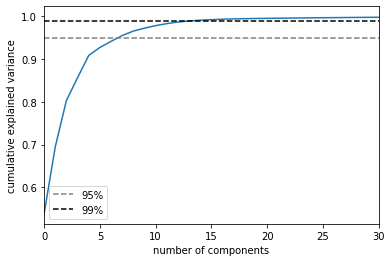

In [46]:
# estimating number of components for pca

pca = PCA().fit(lc_ft)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.95, linestyle='--', c='gray', label='95%')
plt.axhline(0.99, linestyle='--', c='black', label='99%')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.xlim(0, 30)
plt.legend()

In [47]:
# pca fit

pca = PCA(n_components=13)
lc_pca = pca.fit_transform(lc_ft)
lc_pca = pd.DataFrame(lc_pca)
lc_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-15412.350021,-8136.681773,-7327.012135,-4042.440735,-24.074548,-3296.031948,-129.704122,-1683.585770,-1218.771491,-2030.280737,-831.415341,-1499.130436,1.600385
1,-15614.782248,-9065.203594,-6651.244220,-4843.218092,-665.409731,-2165.117282,264.183201,-2406.772523,-514.227268,-2048.222313,-611.458041,-1714.619253,-934.601990
2,-16996.524716,-7106.999171,-9776.374390,-9627.663293,441.147700,-1619.001047,1084.653372,-3242.211827,1888.100635,-974.530002,-459.673069,-3450.296004,23.262996
3,-15312.746481,-8588.413130,-6924.347241,-5607.463212,70.336796,-2559.600720,87.667155,-1550.843291,-615.749674,-2178.651099,-712.689913,-1240.812471,-1164.214538
4,-13663.548164,-14517.776455,-10470.761769,4100.875040,-5323.617314,-5082.844186,798.620643,-2864.567124,624.378787,-573.304102,123.929984,-7185.210292,565.654310


In [ ]:
# try rbf pca



In [48]:
# k-fold cross validation for imbalanced dataset

cv = KFold(shuffle = True, n_splits = 5, random_state=5)

for train, test in cv.split(lc_pca, targets):
    print('train -  {}   |   test -  {}'.format(
    np.bincount(targets.loc[train]), np.bincount(targets.loc[test])))

train -  [4490   35]   |   test -  [1125    7]
train -  [4492   33]   |   test -  [1123    9]
train -  [4497   29]   |   test -  [1118   13]
train -  [4494   32]   |   test -  [1121   10]
train -  [4487   39]   |   test -  [1128    3]


# Decision tree

In [51]:
cross_validate(model1, lc_pca, targets, cv = cv, scoring = 'accuracy', return_train_score = True)

{'fit_time': array([0.03714609, 0.03028488, 0.02801108, 0.03518152, 0.0380671 ]),
 'score_time': array([0.00108242, 0.00208807, 0.00100017, 0.00240088, 0.00100994]),
 'test_score': array([0.98409894, 0.98321555, 0.98585323, 0.98320071, 0.98496905]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [53]:
model1 = DecisionTreeClassifier(random_state=5)

cross_validate(model1, lc_pca, targets, cv = cv, scoring = 'precision', return_train_score = True)

{'fit_time': array([0.04317427, 0.02029037, 0.02633572, 0.02557492, 0.03478479]),
 'score_time': array([0.0010004 , 0.        , 0.00250697, 0.0070684 , 0.        ]),
 'test_score': array([0., 0., 0., 0., 0.]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [52]:
model1 = DecisionTreeClassifier(random_state=5)

cross_validate(model1, lc_pca, targets, cv = cv, scoring = 'recall', return_train_score = True)

{'fit_time': array([0.04494548, 0.03230834, 0.02672172, 0.03074074, 0.03417563]),
 'score_time': array([0.00199938, 0.00255942, 0.00206923, 0.0010016 , 0.00201201]),
 'test_score': array([0., 0., 0., 0., 0.]),
 'train_score': array([1., 1., 1., 1., 1.])}

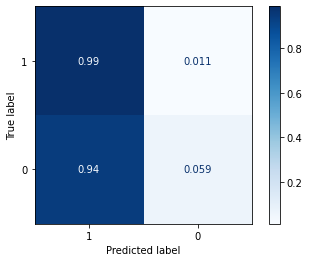

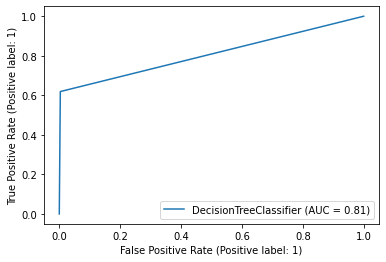

In [54]:
X_train, X_test, y_train, y_test = train_test_split(lc_pca, targets, test_size=0.30)

model1.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(
    model1,
    X_test,
    y_test,
    display_labels=[1,0],
    cmap=plt.cm.Blues,
    normalize='true',
)

RocCurveDisplay.from_estimator(model1, lc_pca, targets)

In [39]:
dot_data = StringIO()
export_graphviz(
            model1,
            out_file =  dot_data,
            feature_names = lc_pca.columns,
            class_names = ['1','0'],
            filled = True,
            rounded = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
nodes = graph.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]
        values = [255 * v / sum(values) for v in values]
        
        values = [int(255 * v / sum(values)) for v in values]
            
        if values[0] > values[1]:
            alpha = int(values[0] - values[1])
            alpha = '{:02x}'.format(alpha) #turn into hexadecimal
            color = 'blue'+str(alpha)
        else:
            alpha = int(values[1] - values[0])
            alpha = '{:02x}'.format(alpha)
            color = 'orange'+str(alpha)
        node.set_fillcolor(color)

graph.set_dpi('100')

Image(graph.create_png())
#Image(graph.write_png())

InvocationException: GraphViz's executables not found

slack variable?

# kNN classifier

In [35]:
# splitting train and test data

X_train, X_test, y_train, y_test = train_test_split(lc_pca, targets, test_size=0.30)


In [57]:
# scaling train data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

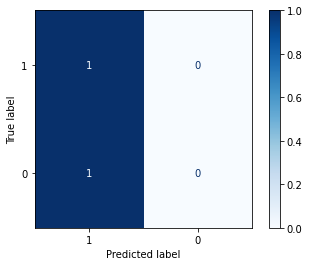

In [58]:
model2 = KNeighborsClassifier()

model2.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(
    model2,
    X_test,
    y_test,
    display_labels=[1,0],
    cmap=plt.cm.Blues,
    normalize='true',
)

# Ignore now

In [74]:
from scipy import ndimage

lc_sigma = ndimage.gaussian_filter1d(lc, axis=0, sigma=5)

In [75]:
from sklearn.preprocessing import normalize ## MinMaxScaler is applied column-wise, Normalizer is apllied row-wise.

lc_norm= normalize(lc_sigma)
lc_norm

array([[ 5.72674956e-03,  5.77388181e-03,  1.11190052e-03, ...,
         1.24291355e-02,  9.29054550e-03,  6.39821535e-03],
       [ 5.14771442e-03,  5.19621088e-03,  7.22127336e-04, ...,
         1.43633367e-02,  1.14905779e-02,  8.82241913e-03],
       [ 4.07284021e-03,  4.12211197e-03,  1.99470156e-05, ...,
         1.78334093e-02,  1.54806738e-02,  1.32560499e-02],
       ...,
       [ 6.93889976e-02,  6.14299159e-02,  5.86875997e-02, ...,
        -1.09384744e-02, -7.24219393e-03, -2.62406688e-03],
       [ 6.93504270e-02,  6.15178773e-02,  5.86543896e-02, ...,
        -1.05946866e-02, -6.81254262e-03, -2.17982780e-03],
       [ 6.93252430e-02,  6.15562226e-02,  5.86322508e-02, ...,
        -1.04277884e-02, -6.60505594e-03, -1.96574916e-03]])

In [76]:
from scipy.signal import savgol_filter



window_length = 500
polyorder = 2
lc_smooth = savgol_filter(lc_norm, window_length, polyorder)
lc_movavg = lc.rolling(window=50).mean(center=True)

In [77]:
lc_smooth = pd.DataFrame(lc_smooth)

In [78]:
lc_smooth.describe()

,0,1,2,3,4,5,6,7,8,9,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
count,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,...,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000
mean,0.003157,0.003165,0.003173,0.003181,0.003189,0.003196,0.003204,0.003212,0.003220,0.003227,...,-0.000217,-0.000221,-0.000225,-0.000229,-0.000233,-0.000237,-0.000241,-0.000245,-0.000249,-0.000254
std,0.018898,0.018779,0.018661,0.018544,0.018427,0.018312,0.018197,0.018083,0.017970,0.017858,...,0.015069,0.015160,0.015251,0.015343,0.015436,0.015530,0.015625,0.015720,0.015816,0.015913
min,-0.074186,-0.073650,-0.073116,-0.072583,-0.072053,-0.071524,-0.070997,-0.070472,-0.069949,-0.069427,...,-0.056875,-0.057027,-0.057180,-0.057333,-0.057486,-0.057640,-0.057793,-0.057947,-0.058101,-0.058255
25%,-0.007104,-0.007033,-0.006993,-0.006936,-0.006898,-0.006862,-0.006814,-0.006784,-0.006739,-0.006688,...,-0.008318,-0.008383,-0.008421,-0.008466,-0.008509,-0.008533,-0.008567,-0.008597,-0.008649,-0.008698
50%,0.002183,0.002211,0.002187,0.002190,0.002200,0.002224,0.002221,0.002225,0.002248,0.002280,...,-0.000183,-0.000197,-0.000198,-0.000202,-0.000217,-0.000226,-0.000219,-0.000237,-0.000253,-0.000270
75%,0.013802,0.013713,0.013640,0.013578,0.013487,0.013375,0.013325,0.013275,0.013204,0.013109,...,0.008430,0.008465,0.008535,0.008567,0.008630,0.008684,0.008721,0.008757,0.008781,0.008823
max,0.066159,0.065674,0.065191,0.064740,0.064299,0.063859,0.063421,0.062984,0.062549,0.062114,...,0.060194,0.060792,0.061392,0.061994,0.062599,0.063207,0.063817,0.064429,0.065043,0.065661


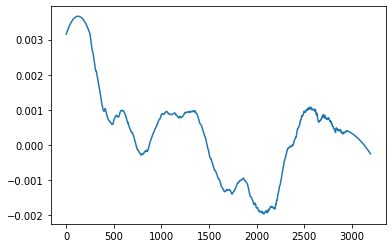

In [79]:
plt.plot(range(0, len(lc_smooth.columns)), lc_smooth.mean())

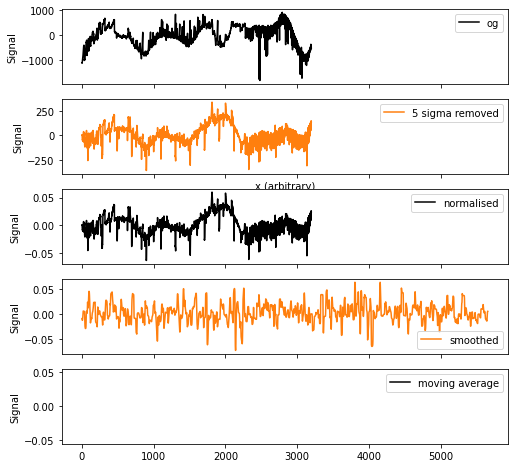

In [80]:
i = 4

fig, axs = plt.subplots(5,1, sharex=True, figsize=(8,8))

axs[0].plot(range(0, len(lc.loc[i])), lc.loc[i], 'k', label='og')
axs[1].plot(range(0, len(lc_sigma[i])), lc_sigma[i], 'C1', label='5 sigma removed')
axs[2].plot(range(0, len(lc_norm[i])), lc_norm[i], 'k', label='normalised')
axs[3].plot(range(0, len(lc_smooth[i])), lc_smooth[i], 'C1', label='smoothed')
axs[4].plot(range(0, len(lc_movavg.loc[i])), lc_movavg.loc[i], 'k', label='moving average')


for ax in axs:
    ax.legend()
    ax.set_ylabel('Signal')
    
axs[1].set_xlabel('x (arbitrary)')

plt.show()

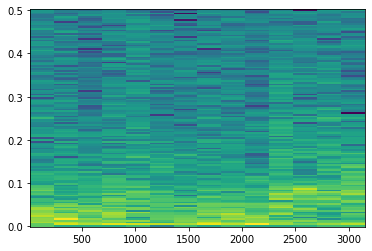

In [81]:
from scipy import signal

dt = lc_norm[0]
time_samps = np.arange(0, len(dt))
fs = 1/(time_samps[1] - time_samps[0])

f, t, Sxx = signal.spectrogram(dt, fs)
plt.pcolormesh(t, f, np.log10(Sxx), shading='auto')

In [82]:
# Autocorrelation

x = lc_smooth[4]

acf = np.correlate(x, x, 'full')[-len(x):]
inflection = np.diff(np.sign(np.diff(acf))) # Find the second-order differences
peaks = (inflection < 0).nonzero()[0] + 1 # Find where they are negative
delay = peaks[acf[peaks].argmax()] # Of those, find the index with the maximum value

#plt.scatter(range(0,len(inflection)), inflection)
delay

1164

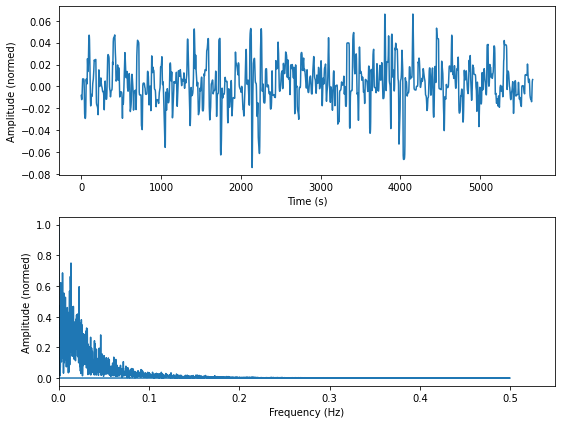

In [83]:
##Do the fourier transform
sine_wave = lc_smooth[0]
time_samps = np.arange(0, len(sine_wave))
ft_sine_wave = np.fft.fft(sine_wave) 

##I'm going to normalise so that the maximum
##is set to 1.0. We'll take about proper normalisatiom
##later in the notebook

ft_sine_wave /= max(np.abs(ft_sine_wave))

##We need the time resolution to work out the sampled frequencies
time_res = time_samps[1] - time_samps[0]

##Uses the number of samples and sampling resolution
##to calculate the inverse coords (frequencies) sampled
ft_frequencies = np.fft.fftfreq(len(sine_wave),time_res)

##Plot the whole plot
fig, axs = plt.subplots(2,1,figsize=(8,6))

axs[0].plot(time_samps, sine_wave)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (normed)')


axs[1].plot(ft_frequencies, abs(ft_sine_wave))
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Amplitude (normed)')
axs[1].set_xlim(0,None)

plt.tight_layout()
plt.show()

In [84]:
##Do the fourier transform
sine_wave = lc_smooth[5111]
time_samps = np.arange(0, len(sine_wave))
ft_sine_wave = np.fft.fft(sine_wave) 

##I'm going to normalise so that the maximum
##is set to 1.0. We'll take about proper normalisatiom
##later in the notebook

#ft_sine_wave /= max(np.abs(ft_sine_wave))

##We need the time resolution to work out the sampled frequencies
time_res = time_samps[1] - time_samps[0]

##Uses the number of samples and sampling resolution
##to calculate the inverse coords (frequencies) sampled
ft_frequencies = np.fft.fftfreq(len(sine_wave),time_res)

##Plot the whole plot
fig, axs = plt.subplots(2,1,figsize=(8,6))

axs[0].plot(time_samps, sine_wave)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (normed)')


axs[1].plot(ft_frequencies, abs(ft_sine_wave))
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Amplitude (normed)')
axs[1].set_xlim(0,None)

plt.tight_layout()
plt.show()

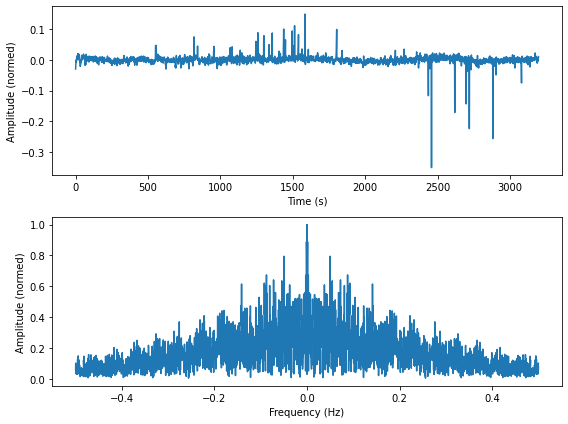

In [ ]:


##Do the fourier transform, and shift it to have
##the zero frequency at the centre, all in one line
ft_sine_wave = np.fft.fftshift(np.fft.fft(sine_wave))

##I'm going to normalise so that the maximum
##is set to 1.0. We'll take about proper normalisatiom
##later in the notebook
ft_sine_wave /= max(np.abs(ft_sine_wave))

##We need the time resolution to work out the sampled frequencies
time_res = time_samps[1] - time_samps[0]

##Uses the number of samples and sampling resolution
##to calculate the inverse coords (frequencies) sampled
##Again, reorder to have the central zero frequency
ft_frequencies = np.fft.fftshift(np.fft.fftfreq(len(sine_wave),time_res))

##Plot the whole plot
fig, axs = plt.subplots(2,1,figsize=(8,6))

axs[0].plot(time_samps, sine_wave)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (normed)')

##Change to plotting circles
axs[1].plot(ft_frequencies, abs(ft_sine_wave))
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Amplitude (normed)')

##set to look at interesting range


##This plots a vertical line at our wave frequency
#axs[1].axvline(freq,linestyle='--',color='k')

plt.tight_layout()
plt.show()